# **Modeling the mind of a predator: Interactive cognitive maps support flexible avoidance of dynamic threats**

### Toby Wise, Caroline J Charpentier, Peter Dayan & Dean Mobbs

## Analysis notebook 1 - Prediction, confidence and reward weight estimation

This notebook contains code for analyses of predator move prediction data and reward weight estimates from Experiment 1.

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import os
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as T
import arviz as az
from scipy.stats import ttest_1samp
import pickle
import matplotlib.font_manager
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('toby2')
plt.rcParams["font.family"] = "Heebo"

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load in data

In [3]:
rating_dfs = []
rt_dfs = []
confidence_dfs = []
prediction_dfs = []
response_dfs = []

output_dir = '../../data/'
experiment = 'experiment-1'

data_dfs = {'rating_data': rating_dfs, 'rt_data': rt_dfs, 'confidence_data': confidence_dfs, 'prediction_data': prediction_dfs, 'response_data': response_dfs}

for data_type, df_list in data_dfs.items():
    
    data_type_dir = os.path.join(output_dir, data_type, experiment)
    
    conditions = os.listdir(data_type_dir)
    
    for c in conditions:
        for i in os.listdir(os.path.join(data_type_dir, c)):
            if '.csv' in i:
                df = pd.read_csv(os.path.join(data_type_dir, c, i))
                df_list.append(df)

rating_df = pd.concat(rating_dfs)
rt_df = pd.concat(rt_dfs)
confidence_df = pd.concat(confidence_dfs)
prediction_df = pd.concat(prediction_dfs)
response_df = pd.concat(response_dfs)

### Separate prey and predator movements

In [273]:
prey_df = response_df[response_df['agent'] == 'prey'].reset_index(drop=True)
predator_df = response_df[response_df['agent'] == 'predator'].reset_index(drop=True)

### Put dataframes in the right order

Makes things a little easier later

In [274]:
prediction_df = prediction_df.sort_values(['subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)
predator_df = predator_df.sort_values(['subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)
prey_df = prey_df.sort_values(['subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)

### Load in environment data

Information about the environments is stored in JSON files, we use a function from `maMDP` to load these in as `MDP` objects

In [275]:
import json
from maMDP.env_io import hex_environment_from_dict
envs = {}
for cond in ['A', 'B', 'C']:
    with open('../../data/game_info/experiment-1/condition_{0}.json'.format(cond), 'r') as f:
        game_info = json.load(f)
    envs[cond] = [hex_environment_from_dict(env, ['Dirt', 'Trees', 'Reward']) for env in game_info['environments']]

### Check that predictions and actual moves line up

In [276]:
assert np.all(prediction_df['subjectID'] == predator_df['subjectID']), 'Subject ID columns do not match'
assert np.all(prediction_df['condition'] == predator_df['condition']), 'Condition columns do not match'
assert np.all(prediction_df['trial'] == predator_df['trial']), 'Trial columns do not match'
assert np.all(prediction_df['response_number'] == predator_df['response_number']), 'Response number columns do not match'

### Get numbers of subjects

Note that some subject IDs are missing - problems in data saving were encountered fairly frequently due to an awkward Unity issue, so quite a few subjects were missing the occasional trial and were removed prior to analysis. 

In [277]:
for c in prediction_df['condition'].unique():
    print('Condition {0}: {1} subjects'.format(c, len(prediction_df[prediction_df['condition'] == c]['subjectID'].unique())))

Condition A: 50 subjects
Condition B: 50 subjects
Condition C: 50 subjects


### Label as correct or incorrect predictions

In [278]:
prediction_df['correct'] = predator_df['cellID'] == prediction_df['cellID']

### Get proportion correct

In [279]:
predictions_correct = prediction_df.groupby(['subjectID','condition', 'response_number']).mean().reset_index()[['subjectID', 'correct', 'condition','response_number']]
predictions_correct = predictions_correct.rename(columns={'correct': 'Proportion correct'})

# Only look at first prediction
predictions_correct = predictions_correct[predictions_correct['response_number'] == 0]
predictions_correct.head()

,subjectID,Proportion correct,condition,response_number
0,sub0000,0.675,A,0
2,sub0001,0.625,A,0
4,sub0002,0.575,A,0
6,sub0003,0.675,A,0
8,sub0004,0.775,A,0


### Rename variables and plot

In [10]:
predictions_correct = predictions_correct.rename(columns={'condition': 'Reward weights'})

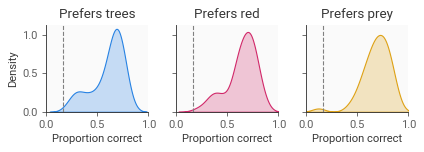

In [203]:
f = sns.displot(predictions_correct, x="Proportion correct", col="Reward weights", hue="Reward weights", height=2, aspect=.9, kind='kde', fill=True, legend=False)

rw_labels = ['Prefers trees', 'Prefers red', 'Prefers prey']

for i in range(len(predictions_correct['Reward weights'].unique())):
    f.axes[0][i].axvline(1 / 6., color='gray', linestyle='--')  # Guessing
    f.axes[0][i].set_xlim(0, 1)
    f.axes[0][i].set_title(rw_labels[i])

plt.tight_layout()
plt.savefig('../../figures/Figure-2_predictions.svg')

Then do t-tests to check that these proportions are significantly greater than chance (i.e. 1/6)

In [13]:
for cond in predictions_correct['Reward weights'].unique():

    pcorrect = predictions_correct[predictions_correct['Reward weights'] == cond]['Proportion correct'].values
    t, p = ttest_1samp(pcorrect, 1 / 6)
    
    print('Condition {0}: T ({1}) = {2}, p = {3}, d={4}'.format(cond, len(pcorrect) - 1, t, p, pg.compute_effsize_from_t(t, N=len(pcorrect), eftype='cohen')))

Condition A: T (49) = 20.2100353548217, p = 2.040337758571713e-25, d=5.716261218965719
Condition B: T (49) = 23.08747501055969, p = 5.515166707038368e-28, d=6.530124056176685
Condition C: T (49) = 27.1194366153494, p = 3.6377576016637708e-31, d=7.670535013068925


## Predictions over time

This looks at whether subjects' predictions improve over time, likely reflecting learning about the predator's behaviour.

First, we look at the proportion of correct predictions (across subjects) at each trial.

In [14]:
predictions_correct_time = prediction_df.groupby(['condition', 'trial', 'response_number']).mean().reset_index()[['trial', 'correct', 'condition','response_number']]
predictions_correct_time = predictions_correct_time.rename(columns={'correct': 'Proportion correct'})

# Only look at first prediction
predictions_correct_time = predictions_correct_time[predictions_correct_time['response_number'] == 0]
predictions_correct_time.head()

,trial,Proportion correct,condition,response_number
0,0,0.475,A,0
2,1,0.600,A,0
4,2,0.640,A,0
6,3,0.790,A,0
8,4,0.730,A,0


## Regression model

For the purposes of modeling, we select only the first move and predict the likelihood of this being correct.

This model is specified heirarchically (i.e. the subject-level regression $\beta$ values are dependent upon group-level $\beta$ parameters). A [non-centred parameterisation](https://mc-stan.org/docs/2_29/stan-users-guide/reparameterization.html#hierarchical-models-and-the-non-centered-parameterization) is used to improve parameter estimation.

In [16]:
prediction_df_first = prediction_df[prediction_df['response_number'] == 0]  # Get first move only

n_subs = len(prediction_df_first['subjectID'].unique())
subject_idx = np.arange(n_subs).repeat(len(prediction_df_first) / n_subs)

with pm.Model() as prediction_model:
    
    trial_effect_mean = pm.Normal('trial_effect_mean', 0, 5)
    trial_effect_sd = pm.HalfNormal('trial_effect_sd', 5)
    trial_effect_offset = pm.Normal('trial_effect_offset', 0, 5, shape=n_subs)
    trial_effect_subject = pm.Deterministic('trial_effect_subject', trial_effect_mean + trial_effect_offset * trial_effect_sd)
    
    game_effect_mean = pm.Normal('game_effect_mean', 0, 5)
    game_effect_sd = pm.HalfNormal('game_effect_sd', 5)
    game_effect_offset = pm.Normal('game_effect_offset', 0, 5, shape=n_subs)
    game_effect_subject = pm.Deterministic('game_effect_subject', game_effect_mean + game_effect_offset * game_effect_sd)
    
    intercept_mean = pm.Normal('intercept_mean', 0, 5)
    intercept_sd = pm.HalfNormal('intercept_sd', 5)
    intercept_offset = pm.Normal('intercept_offset', 0, 5, shape=n_subs)
    intercept_subject = pm.Deterministic('intercept_subject', intercept_mean + intercept_offset * intercept_sd)
    
    predicted_probability = pm.Deterministic('predicted_probability', pm.invlogit(intercept_subject[subject_idx] + trial_effect_subject[subject_idx] * (prediction_df_first['trial'] + 1) + game_effect_subject[subject_idx] * prediction_df_first['env']))
    predicted_probability_group = pm.Deterministic('predicted_probability_group', pm.invlogit(intercept_mean.repeat(4)[:, None] + \
                                                                                              trial_effect_mean * (prediction_df_first['trial'].unique() + 1)[None, :].repeat(4, axis=0) + \
                                                                                              game_effect_mean * prediction_df_first['env'].unique()[:, None].repeat(len(prediction_df_first['trial'].unique()), axis=1)))
    
    ll = pm.Bernoulli('ll', predicted_probability, 
                      observed=prediction_df_first['correct'].astype(int))
    

### Sample

In [17]:
with prediction_model:
    trace = pm.sample(4000, target_accept=0.99, random_seed=123)

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_offset, intercept_sd, intercept_mean, game_effect_offset, game_effect_sd, game_effect_mean, trial_effect_offset, trial_effect_sd, trial_effect_mean]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2272 seconds.
The number of effective samples is smaller than 10% for some parameters.


### Save trace

In [39]:
with open('../../data/regression_models/predictions.pkl', 'wb') as f:
    pickle.dump(trace, f)

### Plot the group-level parameter estimates

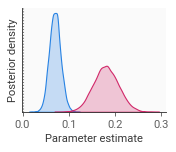

In [43]:
plt.figure(figsize=(2.3, 2))
sns.kdeplot(trace['trial_effect_mean'], fill=True, label='Trial')
sns.kdeplot(trace['game_effect_mean'], fill=True, label='Game')
# plt.title('Trial effect posterior')
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('Parameter estimate')
plt.ylabel('Posterior density')
plt.yticks([])
sns.despine()
plt.tight_layout()

predictions_ax = plt.gca()
# plt.savefig('../../figures/pilot/Figure-2_trial_effect_parameter.svg')

### Get a summary of the parameter estimates

In [19]:
with prediction_model:
    summary = az.summary(trace, var_names=['trial_effect_mean', 'game_effect_mean'], hdi_prob=.95)

In [20]:
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trial_effect_mean,0.07,0.012,0.046,0.095,0.0,0.0,9011.0,10026.0,1.0
game_effect_mean,0.18,0.027,0.128,0.235,0.0,0.0,11488.0,12278.0,1.0


### Use the posterior predictive distribution to demonstrate how P(correct) changes over the task

In [21]:
with prediction_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['predicted_probability_group'], random_seed=123)

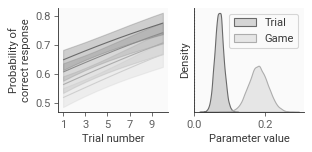

In [205]:
f, ax = plt.subplots(1, 2, figsize=(4, 2))

# seq_pal = sns.light_palette('#006adb', n_colors=10)[2::2]
seq_pal = sns.light_palette('#595959', n_colors=10)[2::2]

for i in range(4):
    m = ppc['predicted_probability_group'][:, i, :].mean(axis=0)
    lower_hdpi = np.percentile(ppc['predicted_probability_group'][:, i, :], 2.5, axis=0)
    upper_hdpi = np.percentile(ppc['predicted_probability_group'][:, i, :], 97.5, axis=0)

    ax[0].fill_between(prediction_df_first['trial'].unique(), lower_hdpi, upper_hdpi, alpha=0.3, color=seq_pal[i])
    ax[0].plot(prediction_df_first['trial'].unique(), m, color=seq_pal[i])
    
# plt.title('Posterior probability of\ncorrect prediction')
ax[0].set_xlabel('Trial number')
ax[0].set_ylabel('Probability of\ncorrect response')

ax[0].set_xticks(range(0, prediction_df_first['trial'].max() + 1, 2))
ax[0].set_xticklabels(np.arange(0, prediction_df_first['trial'].max() + 1, 2) + 1)

sns.kdeplot(trace['trial_effect_mean'], fill=True, label='Trial', ax=ax[1], color=seq_pal[-1])
sns.kdeplot(trace['game_effect_mean'], fill=True, label='Game', ax=ax[1], color=seq_pal[1])
ax[1].set_yticks([])
ax[1].set_xlabel('Parameter value')
ax[1].axvline(0, linestyle=':', color='gray')
ax[1].legend()

sns.despine()

plt.tight_layout()

plt.savefig('../../figures/Figure-2_trial_effect_posterior_predictive_grey.svg')

## Confidence

A similar hierarchical Bayesian model is used to explain confidence over the course of the task

In [23]:
confidence_df = confidence_df.sort_values(['subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)
confidence_df.head()

,env,trial,response_number,confidence,subjectID,exp,condition
0,1,0,0,0.994071,sub0000,1,A
1,1,1,0,1.000000,sub0000,1,A
2,1,2,0,1.000000,sub0000,1,A
3,1,3,0,1.000000,sub0000,1,A
4,1,4,0,0.865335,sub0000,1,A


This model uses a beta likelihood as confidence is bounded between 0 and 1, and use Bambi to specify the model.

In [27]:
confidence_df[''] = confidence_df['confidence'].values.copy()
confidence_df['confidence_fixed'] = (confidence_df['confidence_fixed'] * (np.prod(confidence_df['confidence_fixed'].shape) - 1) + 0.5) / np.prod(confidence_df['confidence_fixed'].shape)

import bambi as bmb
model = bmb.Model("confidence_fixed ~ 1 + env + trial + (1|subjectID) + (env|subjectID) + (trial|subjectID)", data=confidence_df[~confidence_df['confidence'].isnull()], family='beta')
fitted = model.fit(draws=4000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [confidence_fixed_kappa, trial|subjectID_offset, trial|subjectID_sigma, env|subjectID_offset, env|subjectID_sigma, 1|subjectID_offset, 1|subjectID_sigma, Intercept, trial, env]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2614 seconds.


### Save output

In [41]:
az.to_netcdf(fitted, '../../data/regression_models/confidence.nc')

'../../data/regression_models/confidence.nc'

### Plot posteriors for the group-level parameters

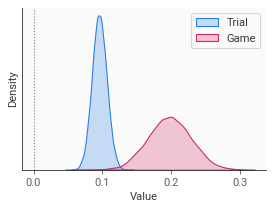

In [106]:
plt.figure(figsize=(3.5, 2.5))
sns.kdeplot(fitted.posterior["trial"].stack(draws=("chain", "draw")).values, fill=True, label='Trial')
sns.kdeplot(fitted.posterior["env"].stack(draws=("chain", "draw")).values, fill=True, label='Game')
plt.legend()
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('Value')
plt.yticks([])
sns.despine()

confidence_ax = plt.gca()

In [29]:
az.summary(fitted, var_names=['trial', 'env'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trial,0.096,0.011,0.075,0.117,0.0,0.0,9902.0,11262.0,1.0
env,0.197,0.032,0.137,0.260,0.0,0.0,7045.0,9711.0,1.0


### Predict using the model parameters' posterior distributions

In [30]:
pred = (fitted.posterior["Intercept"].stack(draws=("chain", "draw")).values[:, None, None] + \
         fitted.posterior["trial"].stack(draws=("chain", "draw")).values[:, None, None] * (prediction_df_first['trial'].unique() + 1)[None, :].repeat(4, axis=0).T[None, ...] + \
         fitted.posterior["env"].stack(draws=("chain", "draw")).values[:, None, None] + prediction_df_first['env'].unique()[:, None].repeat(len(prediction_df_first['trial'].unique()), axis=1).T[None, ...])

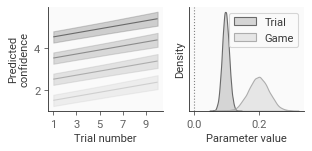

In [328]:
f, ax = plt.subplots(1, 2, figsize=(4, 2))

# seq_pal = sns.light_palette('#006adb', n_colors=10)[2::2]
seq_pal = sns.light_palette('#595959', n_colors=10)[2::2]

for i in range(4):
    m = pred[..., i].mean(axis=0)
    lower_hdpi = np.percentile(pred[..., i], 2.5, axis=0)
    upper_hdpi = np.percentile(pred[..., i], 97.5, axis=0)

    ax[0].fill_between(prediction_df_first['trial'].unique(), lower_hdpi, upper_hdpi, alpha=0.3, color=seq_pal[i])
    ax[0].plot(prediction_df_first['trial'].unique(), m, color=seq_pal[i])
    
# plt.title('Posterior probability of\ncorrect prediction')
ax[0].set_xlabel('Trial number')
ax[0].set_ylabel('Predicted\nconfidence')

ax[0].set_xticks(range(0, prediction_df_first['trial'].max() + 1, 2))
ax[0].set_xticklabels(np.arange(0, prediction_df_first['trial'].max() + 1, 2) + 1)

sns.kdeplot(fitted.posterior["trial"].stack(draws=("chain", "draw")).values, fill=True, label='Trial', ax=ax[1], color=seq_pal[-1])
sns.kdeplot(fitted.posterior["env"].stack(draws=("chain", "draw")).values, fill=True, label='Game', ax=ax[1], color=seq_pal[1])
ax[1].set_yticks([])
ax[1].set_xlabel('Parameter value')
ax[1].axvline(0, linestyle=':', color='gray')
ax[1].legend(loc='upper right')

sns.despine()

plt.tight_layout()

plt.savefig('../../figures/Figure-2_confidence_trial_effect_posterior_predictive_grey.svg')

## Ratings

In [280]:
rating_df = rating_df.sort_values(['subjectID', 'exp', 'condition', 'env']).reset_index(drop=True)
rating_df = rating_df[rating_df['env'] != 0]  # remove training environment
rating_df.head()
rating_df['Reward weights'] = rating_df['condition']
rating_df = rating_df.rename(columns={'rating': 'Rating'})
rating_df['feature'] = rating_df['feature'].str.capitalize()

In [281]:
rating_df['error'] = 0
rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Trees'), 'error'] = 4 - rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Trees'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Prey'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Prey'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Red'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'A') & (rating_df['feature'] == 'Red'), 'Rating']

rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Trees'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Trees'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Prey'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Prey'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Red'), 'error'] = 4 - rating_df.loc[(rating_df['Reward weights'] == 'B') & (rating_df['feature'] == 'Red'), 'Rating']

rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Trees'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Trees'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Prey'), 'error'] = 4 - rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Prey'), 'Rating']
rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Red'), 'error'] = 0 - rating_df.loc[(rating_df['Reward weights'] == 'C') & (rating_df['feature'] == 'Red'), 'Rating']

### Get absolute error

In [282]:
rating_df['error'] = np.abs(rating_df['error'])

### Expected error under the null hypothesis

In [283]:
expected_error = 4  # Assuming subject learns nothing and rates everything as zero - most conservative null

In [284]:
for cond in ['A', 'B', 'C']:

    observed_error = rating_df[rating_df['Reward weights'] == cond].groupby(['subjectID']).mean().reset_index()['error']
    t, p = ttest_1samp(observed_error, 4)

    print('t ({0}) = {1}, p = {2}, d= {3}'.format(len(observed_error)-1, t, p, pg.compute_effsize_from_t(t, N=len(pcorrect), eftype='cohen')))

t (49) = -21.961912814393862, p = 5.167031133660434e-27, d= -6.211766991554254
t (49) = -27.619302501090903, p = 1.56878342473246e-31, d= -7.81191843606558
t (49) = -20.34574256348068, p = 1.5210843608409588e-25, d= -5.754645013965184


In [285]:
rating_df['Reward weights'] = rating_df['Reward weights'].replace({'A': 'Prefers trees', 'B': 'Prefers red', 'C': 'Prefers prey'})

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


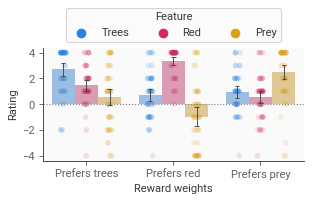

In [320]:
f, ax = plt.subplots(1, 1, figsize=(4, 2.8))

ax.axhline(0, color='gray', linestyle=':')
sns.stripplot('Reward weights', 'Rating', hue='feature', data=rating_df[rating_df['env'] == 4], dodge=True, alpha=0.15, ax=ax, zorder=-1, hue_order=['Trees', 'Red', 'Prey'])
sns.barplot('Reward weights', 'Rating', hue='feature', data=rating_df[rating_df['env'] == 4], alpha=0.5, capsize=.05, errwidth=0.8, ax=ax, hue_order=['Trees', 'Red', 'Prey'])

sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], title='Feature', loc='center', bbox_to_anchor=(.5, 1.2), ncol=3)

plt.tight_layout()
plt.savefig('../../figures/Figure-2_subject_reward_weight_predictions.svg')

### Proportion of subjects performing above chance

In [287]:
observed_error = rating_df.groupby(['subjectID']).mean().reset_index()['error']
(observed_error < 4).sum() / len(observed_error)

0.9933333333333333

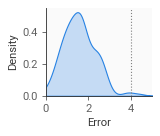

In [326]:
plt.figure(figsize=(2.1, 1.8))

sns.kdeplot(observed_error, fill=True, clip=(0, None))
plt.axvline(4, color='gray', linestyle=':')
plt.xlim(0, 5)
plt.xlabel('Error')
sns.despine()
plt.tight_layout()
plt.savefig('../../figures/Figure-2_subject_reward_weight_error.svg')